In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
# class EncDec(nn.Module):
#     def __init__(self):
#         super(EncDec, self).__init__()
#         self.bn16 = nn.BatchNorm2d(16)
#         self.bn32 = nn.BatchNorm2d(32)
#         self.bn64 = nn.BatchNorm2d(64)
        
#         self.conv1 = nn.Conv2d(1, 64, 3, 2, 1) # Encoder - 1
#         self.conv2 = nn.Conv2d(64, 64, 3, 2, 1) # Encoder - 2
#         self.conv3 = nn.Conv2d(64, 64, 3, 2, 1) # Encoder - 3 
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear') #, align_corners=True
#         self.conv3_t = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 3
#         self.conv2_t = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 2
#         self.conv1_t = nn.Conv2d(64, 1, 3, 1, 1) # Decoder - 1
        
#     def forward(self, x):
#         out = F.relu(self.bn64(self.conv1(x)))
#         out = F.relu(self.bn64(self.conv2(out)))
#         out = F.relu(self.bn64(self.conv3(out)))
#         out = F.relu(self.bn64(self.conv3_t(self.upsample(out))))
#         out = F.relu(self.bn64(self.conv2_t(self.upsample(out))))
#         out = (self.conv1_t(self.upsample(out)))
#         return out

In [22]:
# class EncDec(nn.Module):
#     def __init__(self):
#         super(EncDec, self).__init__()
#         self.bn16 = nn.BatchNorm2d(16)
#         self.bn32 = nn.BatchNorm2d(32)
#         self.bn64 = nn.BatchNorm2d(64)
#         self.pool1 = nn.MaxPool2d(2)
        
#         #self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
#         self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 2 
#         self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2 
#         self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 2 
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear',  align_corners=True)
#         self.conv3_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 3
#         self.conv2_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 3
#         self.conv1_t = nn.Conv2d(16, 1, 3, 1, 1) # Decoder - 1
        
#     def forward(self, x):
#         out = F.relu(self.conv1(x))
#         out = self.bn32((F.relu(self.conv2(out))))
#         out = self.bn64(F.relu(self.conv3(out)))
        
#         out = self.bn32(F.relu(self.conv3_t(self.upsample(out))))
#         out = self.bn16(F.relu(self.conv2_t(self.upsample(out))))
#         out = self.conv1_t(self.upsample(out))
        
#         return (out)

In [36]:
class EncDec(nn.Module):
    def __init__(self):
        super(EncDec, self).__init__()
        self.bn16 = nn.BatchNorm2d(16)
        self.bn32 = nn.BatchNorm2d(32)
        self.bn64 = nn.BatchNorm2d(64)
        self.bn128 = nn.BatchNorm2d(128)
        self.bn256 = nn.BatchNorm2d(256)
        
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3 
        self.conv4 = nn.Conv2d(64, 128, 3, 2, 1) # Encoder - 4
        self.conv5 = nn.Conv2d(128, 256, 3, 2, 1) # Encoder - 5
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv5_t = nn.Conv2d(256, 256, 3, 1, 1) # Decoder - 5
        self.conv4_t = nn.Conv2d(256, 128, 3, 1, 1) # Decoder - 4
        self.conv3_t = nn.Conv2d(128, 64, 3, 1, 1) # Decoder - 3
        self.conv2_t = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2
        self.conv1_t = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 1
        self.conv0_t = nn.Conv2d(16, 1, 3, 1, 1) # Final Decoder
        
    def forward(self, x):
        out = (F.relu(self.conv1(x)))
        out = self.bn32(F.relu(self.conv2(out)))
        out = self.bn64(F.relu(self.conv3(out)))
        out = self.bn128(F.relu(self.conv4(out)))
        out = self.bn256(F.relu(self.conv5(out)))
        out = self.upsample(self.bn256(F.relu(self.conv5_t(out))))
        out = self.upsample(self.bn128(F.relu(self.conv4_t(out))))
        out = self.upsample(self.bn64(F.relu(self.conv3_t(out))))
        out = self.upsample(self.bn32(F.relu(self.conv2_t(out))))
        out = self.upsample(self.bn16(F.relu(self.conv1_t(out))))
        out = torch.relu(self.conv0_t(out))
        return out

In [37]:
file = 'lena'
im = imread('../data/denoising/{}.png'.format(file))
noise = imread('../data/denoising/{}-noisy.png'.format(file))
noisy_img = torch.FloatTensor(noise).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)

MAX_EPOCHS = 5000

#for i in range(10):
net = EncDec()
criterion, optimizer = nn.MSELoss(), optim.Adam(net.parameters(), lr=0.01)
eta = torch.randn(*noisy_img.size())

for itr in range(MAX_EPOCHS+1):
    out = net(eta)
    optimizer.zero_grad()
    loss = criterion(out, clean_img)
    loss.backward()
    optimizer.step()

    if itr %100 == 0:
        op_img = net(eta)[0, 0, :, :].transpose(0,1).detach().numpy()
        error = ((op_img - noise)**2).sum()
        print ("Loss = %.4f" % error)
print ('----------')

Loss = 29349.8841
Loss = 1705.0211
Loss = 1118.6149
Loss = 872.4012
Loss = 766.7838
Loss = 679.7730
Loss = 629.7468
Loss = 610.7770
Loss = 631.3887
Loss = 592.8170
Loss = 604.6810
Loss = 558.8262
Loss = 564.8261
Loss = 532.0596
Loss = 542.4361
Loss = 524.8248
Loss = 524.1947
Loss = 557.2119
Loss = 498.9455


KeyboardInterrupt: 

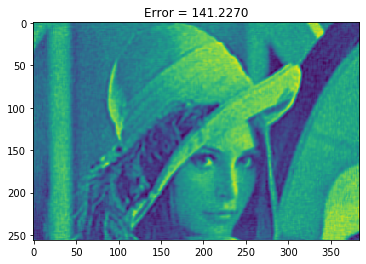

In [28]:
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
curr_error = ((im - out_img)**2).sum()
plt.title('Error = %.4f' % curr_error )
plt.imshow(out_img)
plt.show()

In [ ]:

# Loss = 34417.4082
# Loss = 620.3762
# Loss = 1084.8153
# Loss = 548.9283
# Loss = 454.1465
# Loss = 562.2448
# Loss = 412.8629
# Loss = 400.1701
# Loss = 392.8153
# Loss = 394.5817
# Loss = 433.2168
# Loss = 413.3532
# Loss = 365.7454
# Loss = 517.5175
# Loss = 352.6789
# Loss = 347.1583
# Loss = 356.2893
# Loss = 480.6797
# Loss = 329.1680
# Loss = 326.7244
# Loss = 334.9493
# Loss = 316.5155
# Loss = 338.0170
# Loss = 349.7195
# Loss = 306.2579
# Loss = 305.8346
# Loss = 309.4083
# Loss = 343.1547
# Loss = 305.2139
# Loss = 320.0048
# Loss = 292.9193
# Loss = 341.2247
# Loss = 298.4504
# Loss = 358.1764
# Loss = 310.3693
# Loss = 288.5060
# Loss = 297.4366
# Loss = 278.5177
# Loss = 272.6048
# Loss = 266.9690
# Loss = 266.5631
# Loss = 270.0832
# Loss = 268.3749
# Loss = 310.6882
# Loss = 268.0455
# Loss = 307.4737
# Loss = 260.5465
# Loss = 272.1136
# Loss = 254.2158
# Loss = 254.2177
# Loss = 273.1772